In [1]:
import scipy.io
import numpy as np

# Load the .mat file
data = scipy.io.loadmat('EV_Rank_1_52_RBs_50_UEs_1000_snaps.mat')

# Assuming the key for your dataset within the .mat file is 'csi_data'
# You might need to check the structure of the .mat file to know the exact key.
csi_data = data['EV_re_im_split']

# Check the shape of the loaded data
print("Shape of the loaded data:", csi_data.shape)

# Reshape or manipulate data as needed for the model
# For example, if the data is not in the shape (50, 1000, 832) as expected, you might need to reshape


Shape of the loaded data: (50, 1000, 832)


In [2]:
print(data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'EV_re_im_split'])


In [3]:
from sklearn.preprocessing import StandardScaler

# Reshape data for scaling: (samples * timesteps, features)
n_samples, n_timesteps, n_features = csi_data.shape
data_reshaped = csi_data.reshape(-1, n_features)

# Initialize and fit scaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_reshaped)

# Reshape back to original shape
data_scaled = data_scaled.reshape(n_samples, n_timesteps, n_features)


In [4]:
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data)):
        # find the end of the current sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(data):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix, :], data[end_ix-1:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Setting the window sizes
n_steps_in, n_steps_out = 5, 1

# Apply function to each sample
X, y = [], []
for sample in range(n_samples):
    X_sample, y_sample = create_sequences(data_scaled[sample], n_steps_in, n_steps_out)
    X.append(X_sample)
    y.append(y_sample)

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (49800, 5, 832)
Shape of y: (49800, 1, 832)


In [5]:
from sklearn.model_selection import train_test_split

# Define the ratio of the split
test_size = 0.2

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (39840, 5, 832)
Shape of X_test: (9960, 5, 832)
Shape of y_train: (39840, 1, 832)
Shape of y_test: (9960, 1, 832)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Initialize the model
model = Sequential([
    Bidirectional(LSTM(100, activation='relu', return_sequences=True), input_shape=(5, 832)),
    Dropout(0.3),
    LSTM(100, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(100, activation='relu'),
    Dropout(0.3),
    Dense(832)
])

model.summary()

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 5, 200)         │       746,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 5, 100)         │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 832)            │        84,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,031,232 (3.93 MB)

 Trainable params: 1,031,232 (3.93 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)


In [40]:
# Model training configuration
epochs = 100
batch_size = 32

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,  # Using 10% of the data for validation
    verbose=1,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/100
1120/1121 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9998
Epoch 1: val_loss improved from inf to 1.00046, saving model to best_model.keras
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - loss: 0.9998 - val_loss: 1.0005 - learning_rate: 0.0010
Epoch 2/100
1120/1121 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0000
Epoch 2: val_loss improved from 1.00046 to 1.00046, saving model to best_model.keras
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 1.0000 - val_loss: 1.0005 - learning_rate: 0.0010
Epoch 3/100
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9997
Epoch 3: val_loss improved from 1.00046 to 1.00043, saving model to best_model.keras
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - loss: 0.9998 - val_loss: 1.0004 - learning_rate: 0.0010
Epoch 4/100
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9999
Epoch 4: val_loss did not improve from 1.00043
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - loss: 0.9999 - val_loss: 1.0005 - learning_rate: 0.0010
Epoch 

In [48]:
# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", test_loss)

Test Loss: 0.0004884210648015141


In [49]:
# Making predictions
predictions = model.predict(X_test)


312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [50]:
# Reshape predictions and actual values for inverse scaling
# Assuming the predictions and y_test are already in the shape (n_samples, n_timesteps, n_features)
predictions_reshaped = predictions.reshape(-1, n_features)
y_test_reshaped = y_test.reshape(-1, n_features)

# Inverse transform the predictions and actual values
predictions_inverse = scaler.inverse_transform(predictions_reshaped)
y_test_inverse = scaler.inverse_transform(y_test_reshaped)

# Reshape back to original shape if necessary
predictions = predictions_inverse.reshape(y_test.shape)
y_test = y_test_inverse.reshape(y_test.shape)


In [51]:
import pandas as pd

# Assuming predictions and y_test are ready and have the shape (samples, timesteps, features)
# Let's create a DataFrame for a single feature comparison for the first few timesteps of a sample

# Number of timesteps and sample to display
num_timesteps = 20  # Adjust this as needed
sample_index = 0  # Index of the sample to display

# Create DataFrame
df = pd.DataFrame({
    'Actual': y_test[sample_index, :num_timesteps, 0],  # Adjust index 0 if you want to display a different feature
    'Predicted': predictions[sample_index, :num_timesteps, 0]
})

# Display the DataFrame
print(df)

     Actual  Predicted
0 -0.091843  -0.082814


In [52]:
# Display the first few rows of the DataFrame to check
print(df.head())

     Actual  Predicted
0 -0.091843  -0.082814


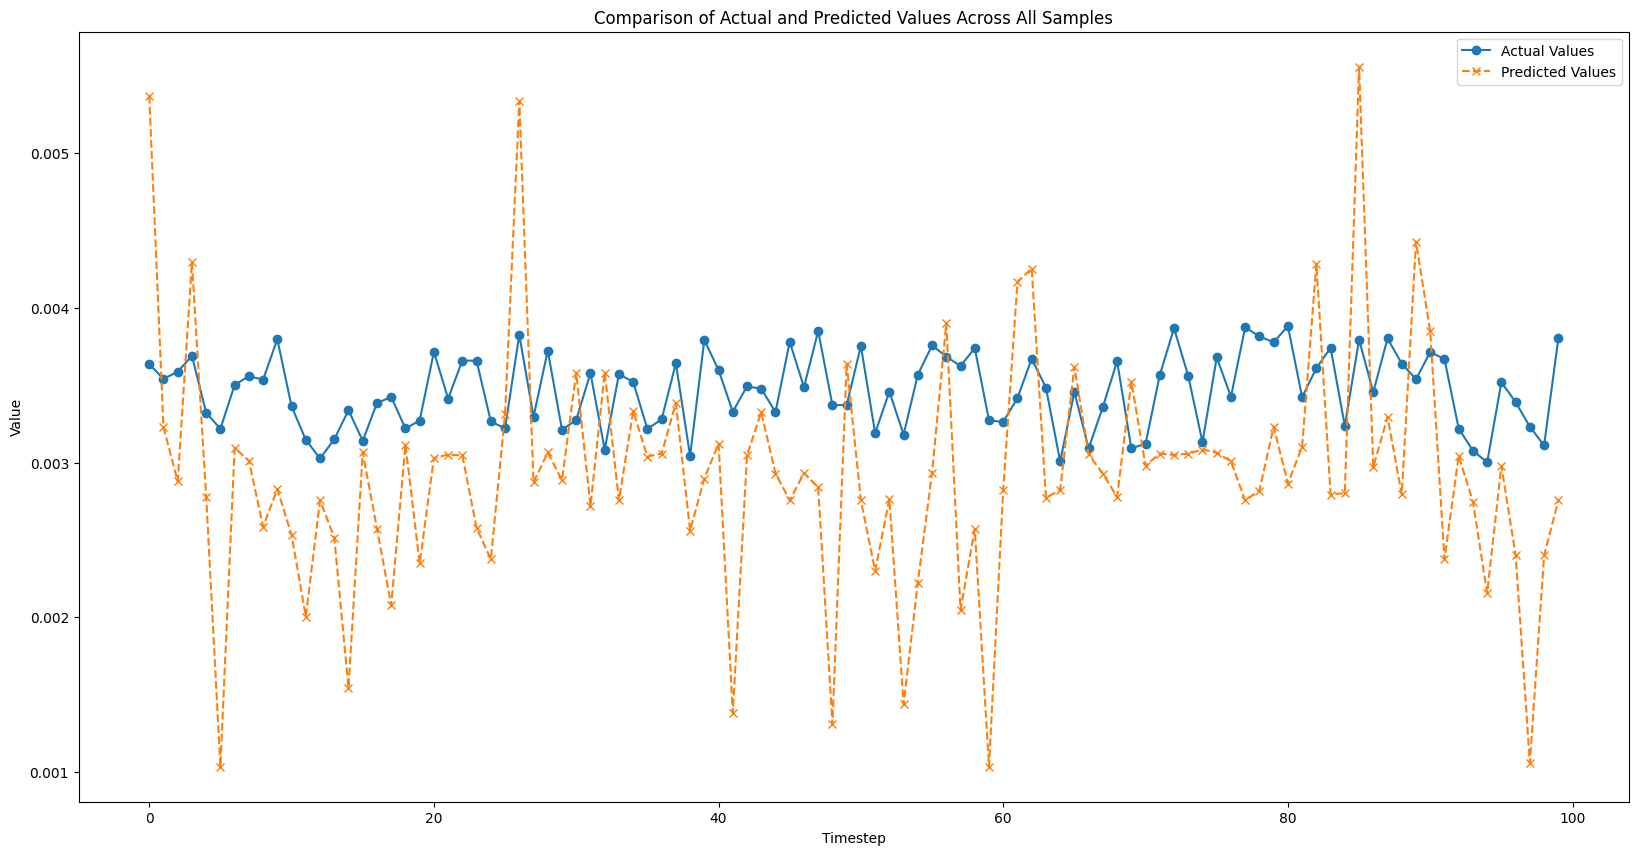

In [56]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Assuming predictions and y_test have the same shape (n_samples, n_timesteps, n_features)
# For simplicity, let's assume we're only plotting the first feature across all timesteps for all samples
till_UE = 100
feature = 800

# Flattening the data for plotting
actual_values = y_test[:till_UE, :, feature].flatten()  # Adjust the index if targeting a different feature
predicted_values = predictions[:till_UE, :, feature].flatten()

# Generating a timeline or x-axis values
time_steps = range(len(actual_values))

# Creating the plot
plt.figure(figsize=(20, 10))
plt.plot(time_steps, actual_values, label='Actual Values', marker='o', linestyle='-')
plt.plot(time_steps, predicted_values, label='Predicted Values', marker='x', linestyle='--')
plt.title('Comparison of Actual and Predicted Values Across All Samples')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()


In [54]:
# Export DataFrame to CSV
# df.to_csv('actual_vs_predicted.csv', index=False)